##Analyzer

Statistically and visually compare mRNA and lncRNA sequences from GenCode.v38.

Assume user downloaded files from GenCode38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

##Import Dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import gzip
from scipy.stats import chisquare, kstest
import sys

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Load GenCode Data
Loads GenCode.v38 data.

Filters out mRNA sequences based on UTR check.

In [2]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))

PC seqs loaded: 70825
NC seqs loaded: 48752


##Process Sequences


Generate Sample of GENCODE Data Set

Apply Length Constraints

Validate Sequences

In [3]:
APPLY_SUBSET = True             #Option to subset the data
MINIMUM_SEQUENCE_LENGTH = 200   #Minimum exclusive length to filter out sequences by
MAXIMUM_SEQUENCE_LENGTH = 4000  #Maximum inclusive length to filter out sequences by
SAMPLE_FRACTION = 1             #What fraction of the GenCode data set to take a sample of
REPRODUCABILITY_SEED = 314159   #Use to reproduce random sampling

In [4]:
if APPLY_SUBSET:
  pcdf = pcdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)
  ncdf = ncdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)

  print('PC sample size:', len(pcdf))
  print('NC sample size:', len(ncdf))

PC sample size: 70825
NC sample size: 48752


Apply Length Constraints

In [5]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [6]:
pc_sequences = pcdf['sequence'].tolist()
nc_sequences = ncdf['sequence'].tolist()

if APPLY_SUBSET:
  pc_sequences = subset_list_by_len_bounds(pc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)
  nc_sequences = subset_list_by_len_bounds(nc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)

  print('PC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(pc_sequences))
  print('NC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(nc_sequences))

#Garbage collection
pcdf = None
ncdf = None

PC seqs in length range (200 - 4000): 55381
NC seqs in length range (200 - 4000): 46912


Validate Sequences

In [7]:
def valid_sequence(seq):
  """
  Checks if the given sequences if valid.
  """
  for chr in seq:
      if not (chr == 'A' or chr == 'C' or chr == 'G' or chr == 'T'):
        return False
  return True

def validate_sequences(sequences):
  """
  Validate the given list of sequences
  """
  i = 0
  while i < len(sequences):
    if valid_sequence(sequences[i]):
      i += 1
    else:
      sequences.remove(sequences[i])

validate_sequences(pc_sequences)
validate_sequences(nc_sequences)

print('Valid PC seqs:', len(pc_sequences))
print('Valid NC seqs:', len(nc_sequences))

Valid PC seqs: 55381
Valid NC seqs: 46911


##Generate Simulated Sequences

---

In [8]:
NUM_FAKE_SEQS_PER_LENGTH = 15
random.seed(REPRODUCABILITY_SEED)
fake_sequences = []
for length in range(MINIMUM_SEQUENCE_LENGTH + 1, MAXIMUM_SEQUENCE_LENGTH + 1):
  for size in range(0, NUM_FAKE_SEQS_PER_LENGTH):
    sequence = ''.join(random.choices(['A', 'C', 'G', 'T'], k=length))
    fake_sequences.append(sequence)

print('Simulated Sequences:', len(fake_sequences))

Simulated Sequences: 57000


##Generate Statistics


Using KmerTools to get the K-mer counts upto 3.
It returns the value in Dictionary form. (Key-Value Pair)

In [9]:
MAX_K = 3
tool = KmerTools()

pc_counts = tool.make_dict_upto_K(MAX_K)
for sample in pc_sequences:
    tool.update_count_one_K(pc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(pc_counts,MAX_K)
pc_freqs = tool.count_to_frequency(pc_counts,MAX_K)

nc_counts = tool.make_dict_upto_K(MAX_K)
for sample in nc_sequences:
    tool.update_count_one_K(nc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(nc_counts,MAX_K)
nc_freqs = tool.count_to_frequency(nc_counts,MAX_K)

fake_counts = tool.make_dict_upto_K(MAX_K)
for sample in fake_sequences:
  tool.update_count_one_K(fake_counts, MAX_K, sample, True)
tool.harvest_counts_from_K(fake_counts, MAX_K)
fake_freqs = tool.count_to_frequency(fake_counts, MAX_K)

#Garbage collection
pc_counts = None
nc_counts = None
fake_counts = None

In [10]:
ONE_MER_MIN = 0
ONE_MER_MAX = 4**1
TWO_MER_MIN = 4**1
TWO_MER_MAX = 4**2 + 4**1
THREE_MER_MIN = 4**2 + 4**1
THREE_MER_MAX = 4**3 + 4**2 + 4**1

one_mer_keys = list(pc_freqs.keys())[ONE_MER_MIN:ONE_MER_MAX]
two_mer_keys = list(pc_freqs.keys())[TWO_MER_MIN:TWO_MER_MAX]
three_mer_keys = list(pc_freqs.keys())[THREE_MER_MIN:THREE_MER_MAX]

pc_freqs = list(pc_freqs.values())
nc_freqs = list(nc_freqs.values())
fake_freqs = list(fake_freqs.values())

one_mer_pc = np.asarray(pc_freqs[ONE_MER_MIN:ONE_MER_MAX])
one_mer_nc = np.asarray(nc_freqs[ONE_MER_MIN:ONE_MER_MAX])
one_mer_fake = np.asarray(fake_freqs[ONE_MER_MIN:ONE_MER_MAX])

two_mer_pc = np.asarray(pc_freqs[TWO_MER_MIN:TWO_MER_MAX])
two_mer_nc = np.asarray(nc_freqs[TWO_MER_MIN:TWO_MER_MAX])
two_mer_fake = np.asarray(fake_freqs[TWO_MER_MIN:TWO_MER_MAX])

three_mer_pc = np.asarray(pc_freqs[THREE_MER_MIN:THREE_MER_MAX])
three_mer_nc = np.asarray(nc_freqs[THREE_MER_MIN:THREE_MER_MAX])
three_mer_fake = np.asarray(fake_freqs[THREE_MER_MIN:THREE_MER_MAX])

#Garbage collection
pc_freqs = None
nc_freqs = None
fake_freqs = None

Generate max ORF lengths

In [11]:
oc = ORF_counter()

pc_max_orf_len = np.empty(1, dtype=object)
nc_max_orf_len = np.empty(1, dtype=object)
fake_max_orf_len = np.empty(1, dtype=object)

pc_max_orf_len[0] = np.zeros(len(pc_sequences))
nc_max_orf_len[0] = np.zeros(len(nc_sequences))
fake_max_orf_len[0] = np.zeros(len(fake_sequences))

for i in range(len(pc_sequences)):
  oc.set_sequence(pc_sequences[i])
  pc_max_orf_len[0][i] = oc.get_max_orf_len()
for i in range(len(nc_sequences)):
  oc.set_sequence(nc_sequences[i])
  nc_max_orf_len[0][i] = oc.get_max_orf_len()
for i in range(len(fake_sequences)):
  oc.set_sequence(fake_sequences[i])
  fake_max_orf_len[0][i] = oc.get_max_orf_len()

Get sequence lengths and sequence length vs. max ORF length correlation coefficients

In [12]:
pc_seq_len = np.asarray(list(map(lambda x : len(x), pc_sequences)))
pc_seq_len_orf_len_corrcoef = np.corrcoef(pc_seq_len, pc_max_orf_len[0])
nc_seq_len = np.asarray(list(map(lambda x : len(x), nc_sequences)))
nc_seq_len_orf_len_corrcoef = np.corrcoef(nc_seq_len, nc_max_orf_len[0])
fake_seq_len = np.asarray(list(map(lambda x : len(x), fake_sequences)))
fake_seq_len_orf_len_corrcoef = np.corrcoef(fake_seq_len, fake_max_orf_len[0])

##Results

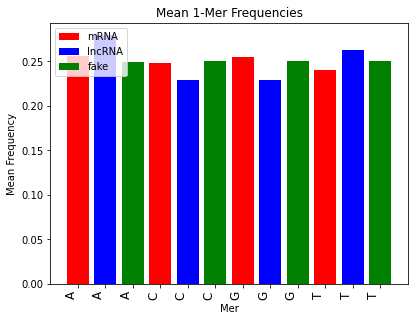

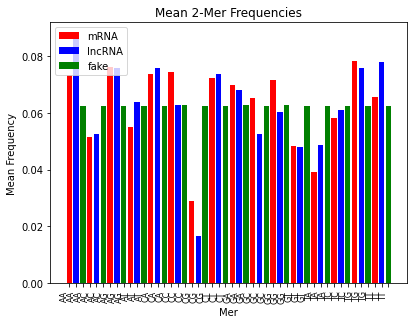

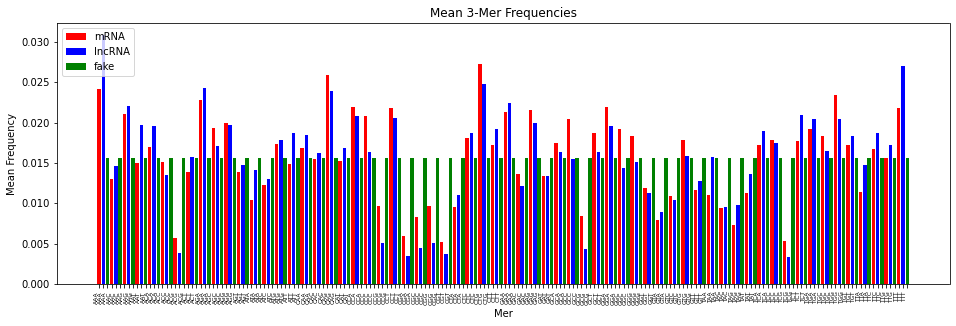

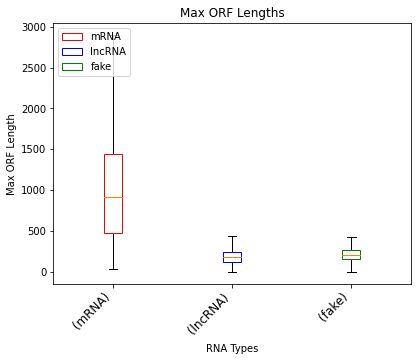

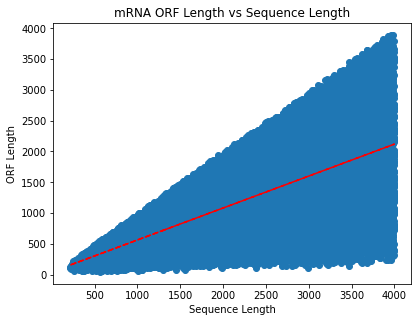

mRNA Sequence Length ORF Length Correlation Coefficient:
	 [[1.         0.71390581]
 [0.71390581 1.        ]]


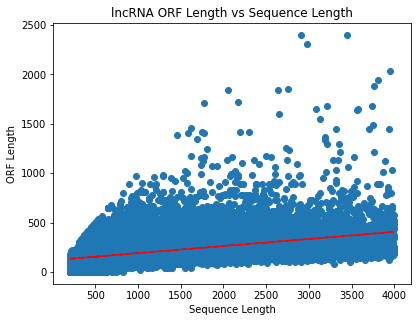

lnc Sequence Length ORF Length Correlation Coefficient:
	 [[1.         0.46743005]
 [0.46743005 1.        ]]


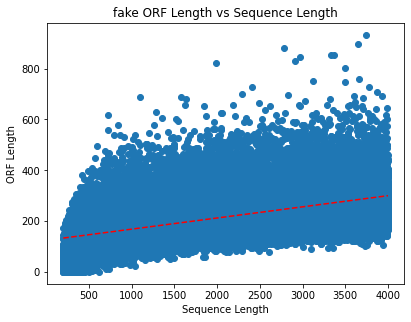

fake Sequence Length ORF Length Correlation Coefficient:
	 [[1.         0.53459943]
 [0.53459943 1.        ]]


In [55]:
data_set_names = ['mRNA', 'lncRNA', 'fake']

pg = PlotGenerator()
pg.set_text_options(90, 'right', 0, 'center', 12)

pg.set_text('Mean 1-Mer Frequencies', 'Mer', 'Mean Frequency', one_mer_keys, None)
pg.bar_plot([one_mer_pc, one_mer_nc, one_mer_fake], data_set_names)

pg.set_text_options(90, 'right', 0, 'center', 8)
pg.set_text('Mean 2-Mer Frequencies', 'Mer', 'Mean Frequency', two_mer_keys, None)
pg.bar_plot([two_mer_pc, two_mer_nc, two_mer_fake], data_set_names)

pg.set_figure_options(width=16)
pg.set_text_options(90, 'right', 0, 'center', 6)
pg.set_text('Mean 3-Mer Frequencies', 'Mer', 'Mean Frequency', three_mer_keys, None)
pg.bar_plot([three_mer_pc, three_mer_nc, three_mer_fake], data_set_names)

pg.set_figure_options()
pg.set_text_options(45, 'right', 0, 'center', 12)
pg.set_text('Max ORF Lengths', 'RNA Types', 'Max ORF Length', [''], None)
pg.box_plot([pc_max_orf_len, nc_max_orf_len, fake_max_orf_len], data_set_names, False)

pg.set_text('mRNA ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(pc_seq_len, pc_max_orf_len[0], trendline=True)
print('mRNA Sequence Length ORF Length Correlation Coefficient:')
print('\t', pc_seq_len_orf_len_corrcoef)

pg.set_text('lncRNA ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(nc_seq_len, nc_max_orf_len[0], trendline=True)
print('lnc Sequence Length ORF Length Correlation Coefficient:')
print('\t', nc_seq_len_orf_len_corrcoef)

pg.set_text('fake ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(fake_seq_len, fake_max_orf_len[0], trendline=True)
print('fake Sequence Length ORF Length Correlation Coefficient:')
print('\t', fake_seq_len_orf_len_corrcoef)

## Set Up MLP

In [44]:
RATIO_TRAIN_TO_TEST = 0.9
INPUT_SHAPE = (None, 4**3 + 4**2 + 4**1)
MAX_K = 3
NEURONS = 256
DROP_RATE = 0.01
EPOCHS = 50
SPLITS = 5
FOLDS = 1

Define what is training data and what is testing data

In [45]:
NUM_PC = len(pc_sequences)
NUM_PC_TRAIN = int(NUM_PC * RATIO_TRAIN_TO_TEST)
NUM_NC = len(nc_sequences)
NUM_NC_TRAIN = int(NUM_NC * RATIO_TRAIN_TO_TEST)

pc_train = pc_sequences[:NUM_PC_TRAIN]
pc_test = pc_sequences[NUM_PC_TRAIN:]
nc_train = nc_sequences[:NUM_NC_TRAIN]
nc_test = nc_sequences[NUM_NC_TRAIN:]

#Garbage Collection (in this instand it makes re-running the MLP a pain)
#pc_sequences = None
#nc_sequences = None

Prepare the Inputs and the Labels

In [46]:
def prepare_x_and_y(seqs1, seqs0):
  """
  From Miller's MLP_GenCode_1??.
  """
  len1=len(seqs1)
  len0=len(seqs0)
  total=len1+len0
  L1=np.ones(len1,dtype=np.int8)
  L0=np.zeros(len0,dtype=np.int8)
  S1 = np.asarray(seqs1)
  S0 = np.asarray(seqs0)
  all_labels = np.concatenate((L1,L0))
  all_seqs = np.concatenate((S1,S0))  
  for i in range(0,len0):
    all_labels[i*2] = L0[i]
    all_seqs[i*2] = S0[i]
    all_labels[i*2+1] = L1[i]
    all_seqs[i*2+1] = S1[i]
  return all_seqs,all_labels  # use this to test unshuffled
  # bug in next line?
  X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
  #Doesn't fix it
  #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
  #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
  return X,y

X,y = prepare_x_and_y(pc_train,nc_train)

In [47]:
#TODO: figure out how to not have to regenerate k-mer frequences

def seqs_to_kmer_freqs(seqs, max_K):
  """
  From Miller's MLP_GenCode_1??.
  """
  tool = KmerTools()  # from SimTools
  empty = tool.make_dict_upto_K(max_K)
  collection = []
  for seq in seqs:
    counts = empty
    # Last param should be True when using Harvester.
    counts = tool.update_count_one_K(counts,max_K,seq,True)
    # Given counts for K=3, Harvester fills in counts for K=1,2.
    counts = tool.harvest_counts_from_K(counts,max_K)
    fdict = tool.count_to_frequency(counts,max_K)
    freqs = list(fdict.values())
    collection.append(freqs)
  return np.asarray(collection)

X = seqs_to_kmer_freqs(X, MAX_K)

##Make and Train MLP

In [48]:
def make_DNN():
  """
  From Miller's MLP_GenCode_1??.
  """
  dt=np.float32
  print("make_DNN")
  print("input shape:",INPUT_SHAPE)
  dnn = Sequential()

  dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  # relu doesn't work as well
  dnn.add(Dropout(DROP_RATE))

  dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
  dnn.add(Dropout(DROP_RATE))

  dnn.add(Dense(1,activation="sigmoid",dtype=dt))  

  dnn.compile(optimizer='adam',    # adadelta doesn't work as well
    loss=BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])   # add to default metrics=loss
  dnn.build(input_shape=INPUT_SHAPE) 
  return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               21760     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 87,809
Trainable params: 87,809
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
def do_cross_validation(X,y):
  """
  From Miller's MLP_GenCode_1??.
  """
  cv_scores = []
  fold=0
  #mycallbacks = [ModelCheckpoint(
  #    filepath=MODELPATH, save_best_only=True, 
  #    monitor='val_accuracy', mode='max')]   
  # When shuffle=True, the valid indices are a random subset.
  splitter = KFold(n_splits=SPLITS,shuffle=True) 
  model = None
  for train_index,valid_index in splitter.split(X):
    if fold < FOLDS:
      fold += 1
      X_train=X[train_index] # inputs for training
      y_train=y[train_index] # labels for training
      X_valid=X[valid_index] # inputs for validation
      y_valid=y[valid_index] # labels for validation
      print("MODEL")
      # Call constructor on each CV. Else, continually improves the same model.
      model = model = make_DNN()
      print("FIT")  # model.fit() implements learning
      start_time=time.time()
      history=model.fit(X_train, y_train, 
        epochs=EPOCHS, 
        verbose=1,  # ascii art while learning
        # callbacks=mycallbacks,   # called at end of each epoch
        validation_data=(X_valid,y_valid))
      end_time=time.time()
      elapsed_time=(end_time-start_time)                        
      print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
      # print(history.history.keys())  # all these keys will be shown in figure
      pd.DataFrame(history.history).plot(figsize=(8,5))
      plt.grid(True)
      plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
      plt.show()
  return model  # parameters at end of training

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/50
2302/2302 [==============================] - 8s 3ms/step - loss: 0.7018 - accuracy: 0.5195 - val_loss: 0.6924 - val_accuracy: 0.5392
Epoch 2/50
2302/2302 [==============================] - 6s 3ms/step - loss: 0.6912 - accuracy: 0.5391 - val_loss: 0.6938 - val_accuracy: 0.4608
Epoch 3/50
2302/2302 [==============================] - 6s 3ms/step - loss: 0.6915 - accuracy: 0.5361 - val_loss: 0.6921 - val_accuracy: 0.5392
Epoch 4/50
2302/2302 [==============================] - 6s 3ms/step - loss: 0.6919 - accuracy: 0.5302 - val_loss: 0.6918 - val_accuracy: 0.5392
Epoch 5/50
2302/2302 [==============================] - 6s 3ms/step - loss: 0.6907 - accuracy: 0.5394 - val_loss: 0.6902 - val_accuracy: 0.5392
Epoch 6/50
2302/2302 [==============================] - 7s 3ms/step - loss: 0.6909 - accuracy: 0.5393 - val_loss: 0.6907 - val_accuracy: 0.5392
Epoch 7/50
2302/2302 [==============================] - 7s 3ms/step - loss: 0.6907 - accuracy

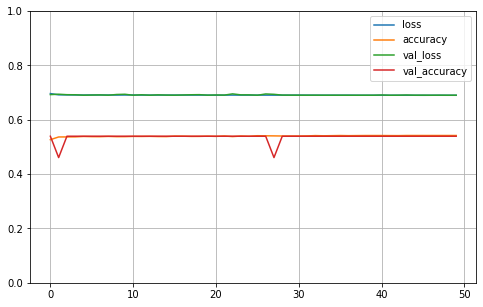

In [50]:
last_model = do_cross_validation(X, y)

##Show Results of MLP

In [51]:
def show_test_AUC(model,X,y):
  """
  From Miller's MLP_GenCode_1??.
  """
  ns_probs = [0 for _ in range(len(y))]
  bm_probs = model.predict(X)
  ns_auc = roc_auc_score(y, ns_probs)
  bm_auc = roc_auc_score(y, bm_probs)
  ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
  bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
  plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
  plt.title('ROC')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
  """
  From MIller's MLP_GenCode_1??.
  """
  scores = model.evaluate(X, y, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Accuracy on training data.
Prepare...
Extract K-mer features...
Plot...


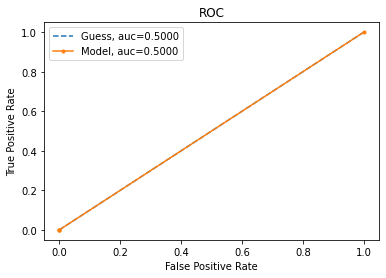

AUC: 50.00%
accuracy: 54.14%


In [52]:
print("Accuracy on training data.")
print("Prepare...")
X, y = prepare_x_and_y(pc_train, nc_train)
print("Extract K-mer features...")
X = seqs_to_kmer_freqs(X, MAX_K)
print("Plot...")
show_test_AUC(last_model, X, y)
show_test_accuracy(last_model, X, y)

Accuracy on test data.
Prepare...
Extract K-mer features...
Plot...


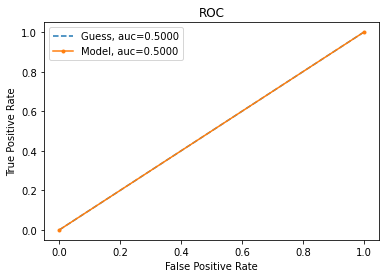

AUC: 50.00%
accuracy: 54.14%


In [53]:
print("Accuracy on test data.")
print("Prepare...")
X, y = prepare_x_and_y(pc_test, nc_test)
print("Extract K-mer features...")
X = seqs_to_kmer_freqs(X, MAX_K)
print("Plot...")
show_test_AUC(last_model, X, y)
show_test_accuracy(last_model, X, y)